In [8]:
# Задача. Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.
# Визуализировать графики зависимости предсказания от параметров модели.

In [13]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

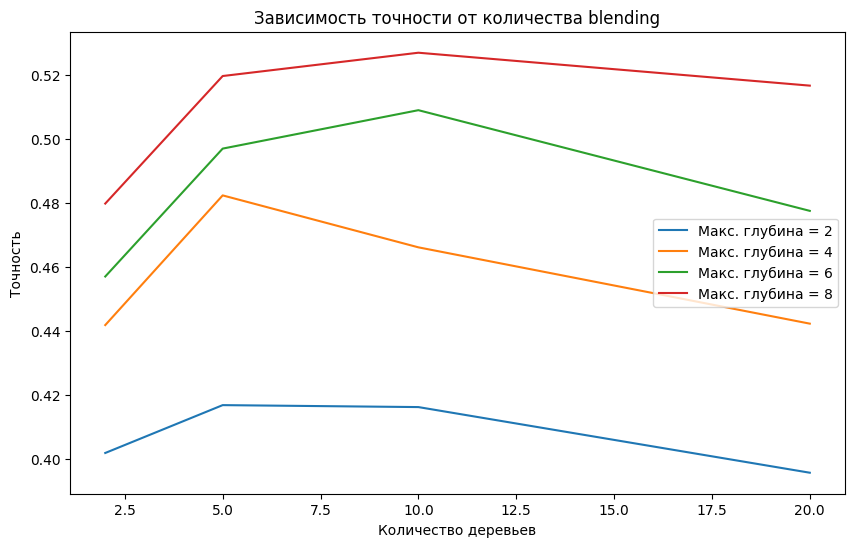

In [14]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

# Преобразование текста в векторное представление
vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])
tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)
X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()
y_train, y_test = dataset['train']['label'], dataset['test']['label']

# Разделение на тренировочную и тестовую выборки
X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

def get_params():
    return [2, 5, 10, 20], [2, 4, 6, 8], [5, 10, 20], [4, 6, 8]

# Визуализация результатов
def visual(results, method):
    n_estimators_list, max_depth_list, _, _ = get_params()

    plt.figure(figsize=(10, 6))

    for max_depth in max_depth_list:
        subset = [
            np.mean([r['accuracy'] for r in results
                    if r['base_max_depth'] == max_depth and r['base_n_estimators'] == n])
            for n in n_estimators_list
        ]
        plt.plot(n_estimators_list, subset, label=f'Макс. глубина = {max_depth}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Точность')
    plt.title(f'Зависимость точности от количества {method}')
    plt.legend()
    plt.show()

    # Блэндинг
def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = [clf.predict(data) for clf in basic_clfs]
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_blending():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []

    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            crf = []
            y_pred_1 = []
            for n in range(1, 11):  # Количество базовых классификаторов в ансамбле
                clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=n)
                clf.fit(X_train_0, y_train_0)
                crf.append(clf)
                y_pred_1.append(clf.predict(X_train_1).reshape(-1, 1))
            y_pred_1t = np.array(y_pred_1).transpose()[0]

            # Перебор параметров финального классификатора
            for fn in final_n_estimators:
                for fd in final_max_depth:
                    clf_final = RandomForestClassifier(n_estimators=fn, max_depth=fd, random_state=42)
                    clf_final.fit(y_pred_1t, y_train_1)

                    # Оценка на тестовых данных
                    y_test_pred = make_blending_prediction(crf, clf_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': n_estimators,
                        'base_max_depth': max_depth,
                        'final_n_estimators': fn,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })
    return results

visual(get_results_blending(), 'blending')

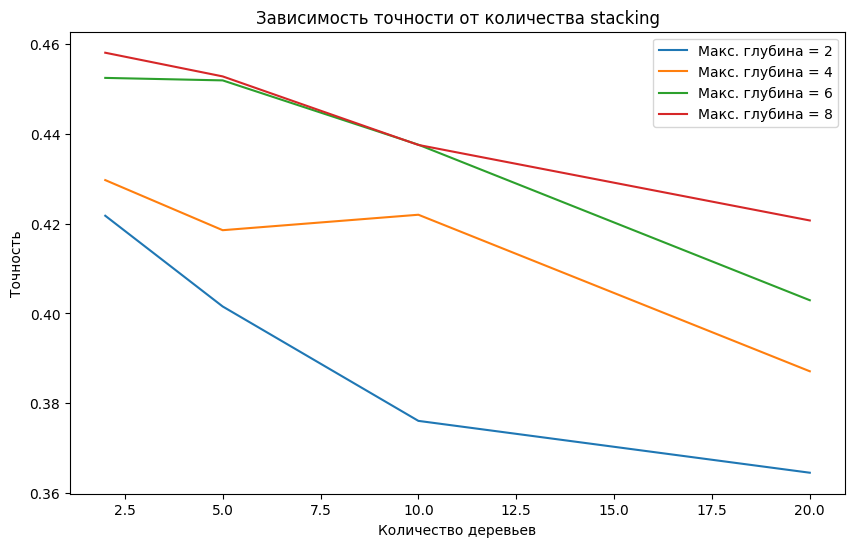

In [15]:
# Стекинг
def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = [clf.predict(data) for clf in basic_clfs]
    y0_t = np.array(y0).transpose()
    return final_clf.predict(y0_t)

def get_results_stacking():
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    results = []

    kf = KFold(n_splits=10, random_state=None, shuffle=True)

    # Перебор параметров базовых классификаторов
    for base_n_estimators in n_estimators_list:
        for base_max_depth in max_depth_list:
            pre_prediction = np.zeros((len(X_train), kf.get_n_splits()))
            crf_stack = []

            # KFold для стекинга
            for i, (train_index, test_index) in enumerate(kf.split(X_train)):
                X_train_0, X_test_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
                y_train_0, y_test_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

                # Базовые классификаторы
                clf = RandomForestClassifier(n_estimators=base_n_estimators, max_depth=base_max_depth, random_state=i)
                clf.fit(X_train_0, y_train_0)
                crf_stack.append(clf)
                pre_prediction[test_index, i] = clf.predict(X_test_1)

            # Перебор параметров финального классификатора
            for final_n in final_n_estimators:
                for fd in final_max_depth:
                    clf_stack_final = RandomForestClassifier(n_estimators=final_n, max_depth=fd, random_state=42)
                    clf_stack_final.fit(pre_prediction, y_train)

                    # Оценка на тестовых данных
                    y_test_pred = make_stacking_prediction(crf_stack, clf_stack_final, X_test)
                    acc = metrics.accuracy_score(y_test, y_test_pred)

                    # Сохраняем результаты
                    results.append({
                        'base_n_estimators': base_n_estimators,
                        'base_max_depth': base_max_depth,
                        'final_n_estimators': final_n,
                        'final_max_depth': fd,
                        'accuracy': acc
                    })

    return results
visual(get_results_stacking(), 'stacking')

In [16]:
# Task
# criterion: “gini”, “entropy”. default=”gini”
# Задание: постройте и визуализируйте структуру решающего дерева
# для критерия разбиения “entropy"

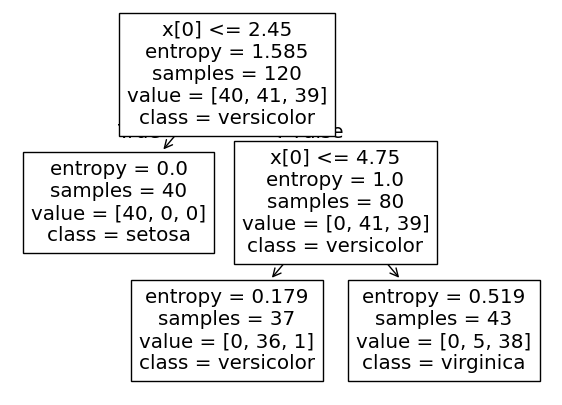

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_classification, load_iris
from sklearn import tree
from matplotlib.colors import ListedColormap

iris = load_iris()
X = iris.data[:, 2:]  # используем только длину и ширину лепестков
y = iris.target
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Классификация с использованием дерева решений
tree_clf_gini = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree_clf_gini.fit(x_train, y_train)
# Визуализация дерева решений
plt.figure(figsize=(7, 5))
tree.plot_tree(tree_clf_gini, class_names=iris.target_names.tolist())  # Преобразуем в список
plt.show()



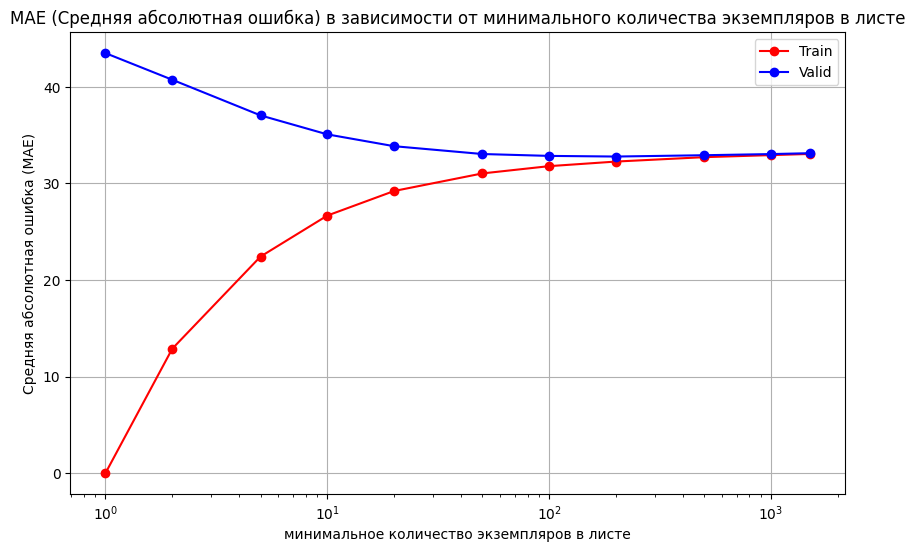

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

train = pd.read_csv('train_features.csv').fillna(0) 
y = pd.read_csv('train_target.csv', index_col='id') 

# Функция для визуализации MAE
def visual_clfs_mae(min_samples_leaf_values, mae_values, mae_train):
    plt.figure(figsize=(10, 6))
    plt.plot(min_samples_leaf_values, mae_train, label='Train', marker='o', linestyle='-', color='r')
    plt.plot(min_samples_leaf_values, mae_values, label='Valid', marker='o', linestyle='-', color='b')
    plt.title('MAE (Средняя абсолютная ошибка) в зависимости от минимального количества экземпляров в листе')
    plt.legend()
    plt.xlabel('минимальное количество экземпляров в листе')
    plt.ylabel('Средняя абсолютная ошибка (MAE)')
    plt.grid(True)
    plt.xscale('log')
    plt.show()

# Функция для тренировки классификаторов
def train_clfs(train, y, real_columns, min_samples_leaf_values = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]):

    x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

    mae_values = []
    mae_train = []

    # Для каждого значения min_samples_leaf обучаем модель и оцениваем MAE
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(x_train, y_train)
        
        mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
        mae_values.append(mean_absolute_error(y_val, model.predict(x_val)))
    visual_clfs_mae(min_samples_leaf_values, mae_values, mae_train)

real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)
train_clfs(train, y, real_columns)

In [34]:
# обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе.
# визуализируйте MAE

In [35]:
# Определяем признаки (количественные переменные)
real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)

# Функция для обучения модели с наилучшими параметрами
def get_mae_best_model(train, y, real_columns, max_depth=21, min_samples_leaf=1000):
    # Разделяем данные на обучающую и валидационную выборки
    x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)
    
    # Обучаем модель с заданными параметрами
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)
    
    # Оценка качества модели на валидационной выборке
    mae = mean_absolute_error(model.predict(x_val), y_val)
    
    return x_train, x_val, y_train, y_val, model, mae

# Обучение модели с лучшими параметрами
x_train, x_val, y_train, y_val, best_model, mae = get_mae_best_model(train, y, real_columns)

# Выводим результат MAE модели с лучшими параметрами
print(f'МАЕ с лучшими параметрами: {mae}')

МАЕ с лучшими параметрами: 33.02198247215921


In [36]:
# выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
# Выбрать оптимальные параметры для каждого дерева.

In [39]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Загрузка данных
train = pd.read_csv('train_features.csv').fillna(0)
y = pd.read_csv('train_target.csv', index_col='id')

# Функция для подбора оптимальных параметров для Bagging Regressor с RandomizedSearchCV
def train_bagging_clf(train, y, real_columns):
    x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)
    # Параметры для RandomizedSearchCV
    param_dist = {
        'n_estimators': [10, 50, 100, 200],  # Количество деревьев
        'estimator__max_depth': [3, 5, 10, 20],  # Глубина деревьев
        'estimator__min_samples_leaf': [1, 2, 5, 10],  # Минимальное количество экземпляров в листе
    }
    
    # Создание Bagging Regressor с DecisionTreeRegressor как базовой моделью
    estimator = DecisionTreeRegressor(random_state=42, max_features='sqrt')
    bagging_regressor = BaggingRegressor(estimator=estimator, random_state=42)

    # Настройка RandomizedSearchCV
    randomized_search = HalvingRandomSearchCV(
        bagging_regressor,
        param_distributions=param_dist,
        factor=2,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
    )

    # Обучение модели
    randomized_search.fit(x_train, y_train)
    
    # Оптимальные параметры
    best_params = randomized_search.best_params_
    print(f"Оптимальные параметры для Bagging Regressor: {best_params}")
    
    # Оценка модели на валидационной выборке
    best_model = randomized_search.best_estimator_
    mae_train = mean_absolute_error(y_train, best_model.predict(x_train))
    mae_val = mean_absolute_error(y_val, best_model.predict(x_val))
    
    print(f'MAE на обучающей выборке: {mae_train}')
    print(f'MAE на валидационной выборке: {mae_val}')

# Выбор признаков
real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)

# Обучаем модель
train_bagging_clf(train, y, real_columns)

C:\All Pro\Programs\Python\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 64 is smaller than n_iter=180764. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\All Pro\Programs\Python\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Оптимальные параметры для Bagging Regressor: {'n_estimators': 200, 'estimator__min_samples_leaf': 10, 'estimator__max_depth': 5}
MAE на обучающей выборке: 33.63308013130345
MAE на валидационной выборке: 33.64113311689819


In [40]:
#### Домашнее задание: 
#### задание для самостоятельной реализации по cross validation (nested k -fold)
#### сформулировать и решить задачу классификации на случайных данных при помощи SVC,
#### тренировку проводить и измерять качество модели c помощью nested k-folds
#### визуализировать ошибку и результаты предсказания

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
#Генерация случайных данных
n_samples = 1000
n_features = 20
n_classes = 2
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=2,
                           n_redundant=10, n_clusters_per_class=1, random_state=42)

In [48]:
svc = SVC()
#Определение внешней и внутренней кросс-валидации
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#Определение сетки гиперпараметров для настройки модели
param_grid = {
    'C': [0.1, 1, 10, 100],    # Регуляризация
    'kernel': ['linear', 'rbf'],  # Тип ядра
    'gamma': ['scale', 'auto']   # Параметр gamma для rbf ядра
}

In [49]:
#Вложенная кросс-валидация с использованием GridSearchCV
scores = []  # Для хранения оценок на внешних фолдах

for train_index, test_index in outer_cv.split(X, y):
    # Разделяем данные на тренировочные и тестовые
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # GridSearchCV для внутреннего поиска гиперпараметров
    grid_search = GridSearchCV(
        estimator=svc, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=inner_cv
    )
    grid_search.fit(X_train, y_train)
    
    # Оцениваем качество на тестовой выборке внешнего фолда
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)


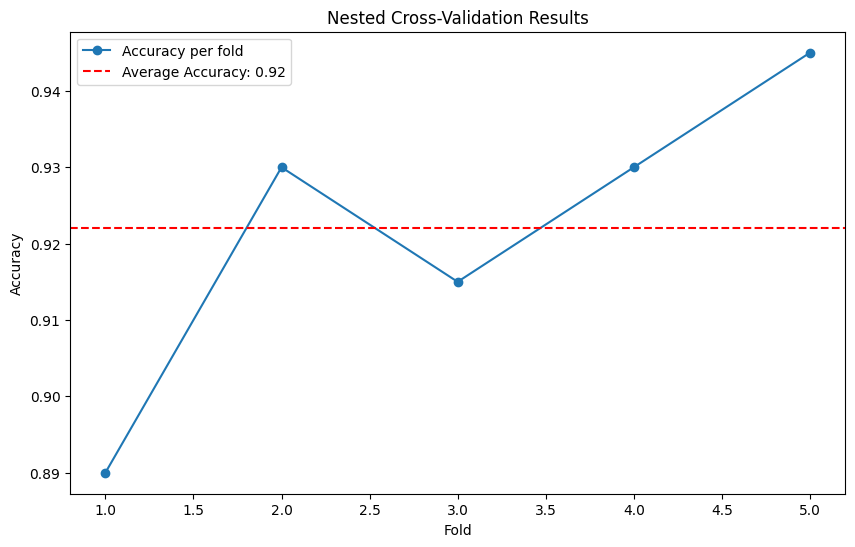

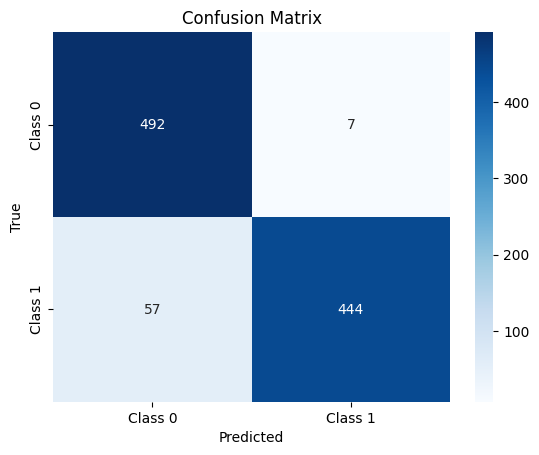

Average Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       499
           1       0.98      0.89      0.93       501

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [51]:
# Построение графика качества
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', label='Accuracy per fold')
plt.axhline(np.mean(scores), color='r', linestyle='--', label=f'Average Accuracy: {np.mean(scores):.2f}')
plt.title('Nested Cross-Validation Results')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Матрица ошибок
y_pred_all = cross_val_score(svc, X, y, cv=outer_cv)
cm = confusion_matrix(y, svc.fit(X, y).predict(X))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Вывод итогов:
print(f'Average Accuracy: {np.mean(scores):.2f}')
print('Classification Report:')
print(classification_report(y, svc.fit(X, y).predict(X)))